# HW1: Frame-Level Speech Recognition

The following notebook produces my max submission on Kaggle. 

'epochs'        : 25,
'batch_size'    : 2048,
'step_size'     : 1,
'gamma'         : 0.1,
'context'       : 28,
'weight_decay'  : 0.01,
'init_lr'       : 1e-3,
'dropout'       : 0.2,

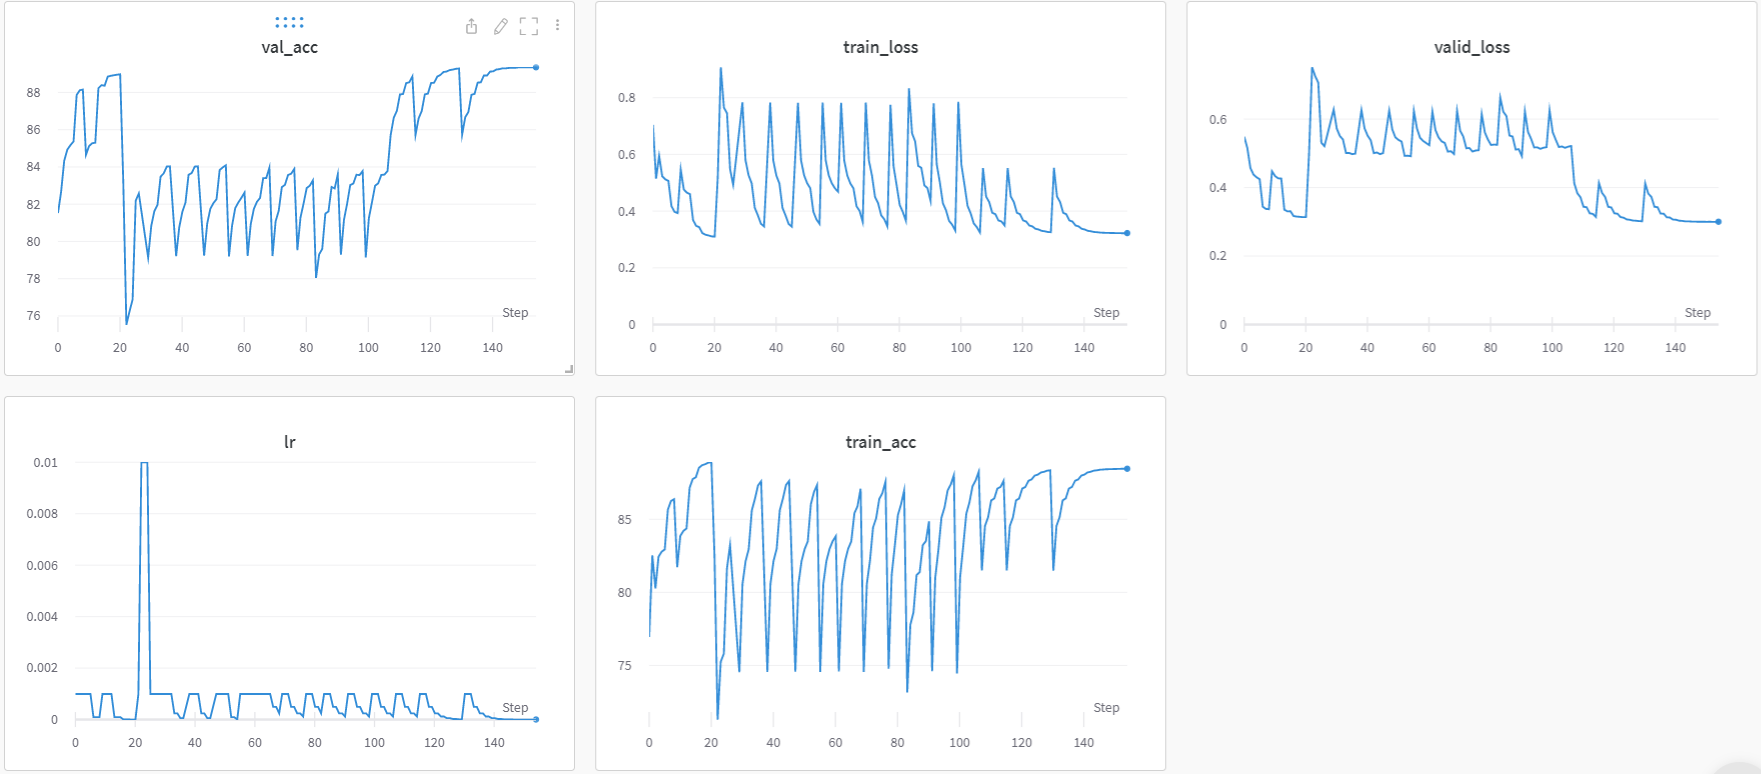

In this homework, you will be working with MFCC data consisting of 27 features at each time step/frame. Your model should be able to recognize the phoneme occured in that frame.

# Libraries

In [ ]:
!pip install torchsummaryX wandb --quiet
!pip install speechpy
!pip install torch-lr-scheduler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import numpy as np
from torchsummaryX import summary
import sklearn
import gc
import zipfile
import pandas as pd
from tqdm.auto import tqdm
import os
import datetime
import wandb
import speechpy
from torch.cuda.amp import GradScaler, autocast
#from torchlr_scheduler.reduce_lr_on_plateau_lr_scheduler import ReduceLROnPlateauScheduler
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


In [ ]:
### PHONEME LIST
PHONEMES = [
            '[SIL]',   'AA',    'AE',    'AH',    'AO',    'AW',    'AY',  
            'B',     'CH',    'D',     'DH',    'EH',    'ER',    'EY',
            'F',     'G',     'HH',    'IH',    'IY',    'JH',    'K',
            'L',     'M',     'N',     'NG',    'OW',    'OY',    'P',
            'R',     'S',     'SH',    'T',     'TH',    'UH',    'UW',
            'V',     'W',     'Y',     'Z',     'ZH',    '[SOS]', '[EOS]']

# Kaggle

This section contains code that helps you install kaggle's API, creating kaggle.json with you username and API key details. Make sure to input those in the given code to ensure you can download data from the competition successfully.

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"sauravkambil","key":"########################"}') 
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# commands to download data from kaggle

#!kaggle competitions download -c 11-785-s23-hw1p2
#!mkdir '/content/data'

#!unzip -qo '11-785-s23-hw1p2.zip' -d '/content/data'

# Dataset

This section covers the dataset/dataloader class for speech data. You will have to spend time writing code to create this class successfully. We have given you a lot of comments guiding you on what code to write at each stage, from top to bottom of the class. Please try and take your time figuring this out, as it will immensely help in creating dataset/dataloader classes for future homeworks.

Before running the following cells, please take some time to analyse the structure of data. Try loading a single MFCC and its transcipt, print out the shapes and print out the values. Do the transcripts look like phonemes?

In [ ]:
class AudioDataset(torch.utils.data.Dataset):
    """A dataset class to load audio data for training and validation."""

    def __init__(self, root_dir, phonemes, context=0, partition="train-clean-100", add_data=False, percentage=1.0):
        """
        Initialize the dataset with the given parameters.
        root_dir: Root directory of the dataset.
        phonemes: List of phonemes used in the dataset.
        context: Number of context frames to include.
        partition: Which partition of the dataset to use.
        add_data: Whether to add additional data from another partition.
        percentage: What percentage of the data to use.
        """
        self.context = context
        self.phonemes = phonemes
        
        # Define directories for MFCC and transcript data
        self.mfcc_dir = os.path.join(root_dir, partition, "mfcc")
        self.transcript_dir = os.path.join(root_dir, partition, "transcript")

        # List files in sorted order
        mfcc_names = sorted(os.listdir(self.mfcc_dir))
        transcript_names = sorted(os.listdir(self.transcript_dir))

        # Ensure there is a one-to-one correspondence between MFCC files and transcripts
        assert len(mfcc_names) == len(transcript_names), "Mismatch in number of MFCC and transcript files"

        # Read a subset of the data as specified by percentage
        length_read = int(len(mfcc_names) * percentage)
        
        # Load and process MFCCs and transcripts
        self.mfccs = [speechpy.processing.cmvn(np.load(os.path.join(self.mfcc_dir, name)))
                      for name in mfcc_names[:length_read]]
        self.transcripts = [np.load(os.path.join(self.transcript_dir, name))[1:-1]  # Remove [SOS] and [EOS]
                            for name in transcript_names[:length_read]]

        # Optionally add data from another partition
        if add_data:
            self._add_additional_data(root_dir, "train-clean-360")

        # Concatenate all MFCCs and transcripts
        self.mfccs = np.vstack(self.mfccs)
        self.transcripts = np.hstack(self.transcripts)
        self.length = len(self.mfccs)
        
        # Pad MFCCs with context frames
        self.mfccs = np.pad(self.mfccs, ((context, context), (0, 0)), 'constant', constant_values=0)
        
        # Map phonemes to integers
        phoneme_to_index = {phoneme: index for index, phoneme in enumerate(self.phonemes)}
        self.transcripts = np.array([phoneme_to_index[phoneme] for phoneme in self.transcripts])

    def _add_additional_data(self, root_dir, additional_partition):
        """Helper method to add additional data from another partition."""
        mfcc_dir = os.path.join(root_dir, additional_partition, "mfcc")
        transcript_dir = os.path.join(root_dir, additional_partition, "transcript")
        for name in os.listdir(mfcc_dir):
            mfcc = speechpy.processing.cmvn(np.load(os.path.join(mfcc_dir, name)))
            transcript = np.load(os.path.join(transcript_dir, name))[1:-1]
            self.mfccs.append(mfcc)
            self.transcripts.append(transcript)

    def __len__(self):
        """Return the total number of frames in the dataset."""
        return self.length

    def __getitem__(self, index):
        """Return the frame at the given index with context and the corresponding phoneme."""
        frames_with_context = self.mfccs[index:index + 2 * self.context + 1].flatten()
        return torch.FloatTensor(frames_with_context), torch.tensor(self.transcripts[index])

In [ ]:
class AudioTestDataset(torch.utils.data.Dataset):
    """Dataset class for loading audio testing data."""

    def __init__(self, root, context=0, partition="test-clean", percentage=1.0):
        """
        Initializes the dataset with the given root directory, context frames, and data partition.

        :param root: Root directory where the data is located.
        :param context: Number of context frames to include.
        :param partition: Data partition to use (e.g., "test-clean").
        :param percentage: Percentage of the data to load (useful for quick tests).
        """
        self.context = context
        self.mfcc_dir = os.path.join(root, partition, "mfcc")

        # List files in the MFCC directory in sorted order
        mfcc_names = sorted(os.listdir(self.mfcc_dir))
        length_read = int(len(mfcc_names) * percentage)
        self.mfccs = []

        # Load and normalize MFCCs
        for i in range(length_read):
            mfcc_path = os.path.join(self.mfcc_dir, mfcc_names[i])
            mfcc = np.load(mfcc_path)
            mfcc = speechpy.processing.cmvn(mfcc)  # Cepstral mean and variance normalization
            self.mfccs.append(mfcc)

        # Concatenate all MFCCs into a single array
        self.mfccs = np.vstack(self.mfccs)
        self.length = len(self.mfccs)

        # Introduce context by padding zeros at the start and end of the MFCC array
        self.mfccs = np.pad(self.mfccs, ((self.context, self.context), (0, 0)), 'constant', constant_values=0)

    def __len__(self):
        """Returns the total number of frames in the dataset."""
        return self.length

    def __getitem__(self, index):
        """
        Retrieves the MFCC frame with context frames at the given index.

        :param index: Index of the frame to retrieve.
        :return: A flattened tensor of MFCC frames including context.
        """
        # Get the frame and its context frames
        frames = self.mfccs[index:index + 2 * self.context + 1]
        frames = frames.flatten()  # Flatten the frames to get a 1D array

        # Convert the frames to a PyTorch tensor
        frames_tensor = torch.FloatTensor(frames)

        return frames_tensor

    # Note: There is no mapping for phonemes to integers as this is a test set without transcripts.

# Parameters Configuration

Storing your parameters and hyperparameters in a single configuration dictionary makes it easier to keep track of them during each experiment. It can also be used with weights and biases to log your parameters for each experiment and keep track of them across multiple experiments. 

In [ ]:
config = {
    'epochs'        : 25,
    'batch_size'    : 2048,
    'step_size'     : 1,
    'gamma'         : 0.1,
    'context'       : 28,
    'weight_decay'  : 0.01,
    'init_lr'       : 1e-3,
    'dropout'       : 0.2,
    'architecture'  : 'very-low-cutoff'
    # Add more as you need them - e.g dropout values, weight decay, scheduler parameters
}

# Create Datasets

In [ ]:
#TODO: Create a dataset object using the AudioDataset class for the training data I CHANGED train-clean-100 to dev-clean
train_data = AudioDataset(context = config['context'], partition="train-clean-100", add_data=True, percentage=1) 

# TODO: Create a dataset object using the AudioDataset class for the validation data 
val_data = AudioDataset(context = config['context'], partition="dev-clean", percentage = 1) 

# TODO: Create a dataset object using the AudioTestDataset class for the test data 
test_data = AudioTestDataset(context = config['context'], partition="test-clean", percentage=1)

In [ ]:
# Define dataloaders for train, val and test datasets
# Dataloaders will yield a batch of frames and phonemes of given batch_size at every iteration
# We shuffle train dataloader but not val & test dataloader. Why?

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data, 
    num_workers = 4,
    batch_size  = config['batch_size'], 
    pin_memory  = True,
    shuffle     = True
)

val_loader = torch.utils.data.DataLoader(
    dataset     = val_data, 
    num_workers = 2,
    batch_size  = config['batch_size'],
    pin_memory  = True,
    shuffle     = False
)

test_loader = torch.utils.data.DataLoader(
    dataset     = test_data, 
    num_workers = 2, 
    batch_size  = config['batch_size'], 
    pin_memory  = True, 
    shuffle     = False
)


print("Batch size     : ", config['batch_size'])
print("Context        : ", config['context'])
print("Input size     : ", (2*config['context']+1)*27)
print("Output symbols : ", len(PHONEMES))

print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Validation dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size     :  2048
Context        :  28
Input size     :  1539
Output symbols :  42
Train dataset samples = 166545152, batches = 81321
Validation dataset samples = 1928204, batches = 942
Test dataset samples = 1934138, batches = 945


In [ ]:
# Testing code to check if your data loaders are working
for i, data in enumerate(train_loader):
    frames, phoneme = data
    print(frames.shape, phoneme.shape)
    break

torch.Size([2048, 1539]) torch.Size([2048])


# Network Architecture


This section defines your network architecture for the homework. We have given you a sample architecture that can easily clear the very low cutoff for the early submission deadline.

In [ ]:
# This architecture will make you cross the very low cutoff
# However, you need to run a lot of experiments to cross the medium or high cutoff
class Network(torch.nn.Module):

    def __init__(self, input_size, output_size):

        super(Network, self).__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(input_size, 1800),
            torch.nn.BatchNorm1d(1800),
            torch.nn.GELU(),
            torch.nn.Dropout(p = config['dropout']),
            torch.nn.Linear(1800, 1800),
            torch.nn.BatchNorm1d(1800),
            torch.nn.GELU(),
            torch.nn.Dropout(p = config['dropout']),
            torch.nn.Linear(1800, 2000),
            torch.nn.BatchNorm1d(2000),
            torch.nn.GELU(),
            torch.nn.Dropout(p = config['dropout']),
            torch.nn.Linear(2000, 2000),
            torch.nn.BatchNorm1d(2000),
            torch.nn.GELU(),
            torch.nn.Dropout(p = config['dropout']),
            torch.nn.Linear(2000, 1745),
            torch.nn.BatchNorm1d(1745),
            torch.nn.GELU(),
            torch.nn.Dropout(p = config['dropout']),
            torch.nn.Linear(1745, 1600),
            torch.nn.BatchNorm1d(1600),
            torch.nn.GELU(),
            #torch.nn.Dropout(p = config['dropout']),
            torch.nn.Linear(1600, output_size)
            
        )      

    def forward(self, x):
        out = self.model(x)

        return out

# Define Model, Loss Function and Optimizer

Here we define the model, loss function, optimizer and optionally a learning rate scheduler. 

In [ ]:
INPUT_SIZE  = (2*config['context'] + 1) * 27 # Why is this the case?
model       = Network(INPUT_SIZE, len(train_data.phonemes)).to(device)
summary(model, frames.to(device))
# Check number of parameters of your network
# Remember, you are limited to 20 million parameters for HW1 (including ensembles)

                         Kernel Shape  Output Shape     Params Mult-Adds
Layer                                                                   
0_model.Linear_0         [1539, 1800]  [2048, 1800]     2.772M   2.7702M
1_model.BatchNorm1d_1          [1800]  [2048, 1800]       3.6k      1.8k
2_model.GELU_2                      -  [2048, 1800]          -         -
3_model.Dropout_3                   -  [2048, 1800]          -         -
4_model.Linear_4         [1800, 1800]  [2048, 1800]    3.2418M     3.24M
5_model.BatchNorm1d_5          [1800]  [2048, 1800]       3.6k      1.8k
6_model.GELU_6                      -  [2048, 1800]          -         -
7_model.Dropout_7                   -  [2048, 1800]          -         -
8_model.Linear_8         [1800, 2000]  [2048, 2000]     3.602M      3.6M
9_model.BatchNorm1d_9          [2000]  [2048, 2000]       4.0k      2.0k
10_model.GELU_10                    -  [2048, 2000]          -         -
11_model.Dropout_11                 -  [2048, 2000]

/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_model.Linear_0,"[1539, 1800]","[2048, 1800]",2772000.0,2770200.0
1_model.BatchNorm1d_1,[1800],"[2048, 1800]",3600.0,1800.0
2_model.GELU_2,-,"[2048, 1800]",NaN,NaN
3_model.Dropout_3,-,"[2048, 1800]",NaN,NaN
4_model.Linear_4,"[1800, 1800]","[2048, 1800]",3241800.0,3240000.0
5_model.BatchNorm1d_5,[1800],"[2048, 1800]",3600.0,1800.0
6_model.GELU_6,-,"[2048, 1800]",NaN,NaN
7_model.Dropout_7,-,"[2048, 1800]",NaN,NaN
8_model.Linear_8,"[1800, 2000]","[2048, 2000]",3602000.0,3600000.0


In [ ]:
criterion = torch.nn.CrossEntropyLoss() # Defining Loss function. 
# We use CE because the task is multi-class classification 

optimizer = torch.optim.AdamW(model.parameters(), lr= config['init_lr'], weight_decay= config['weight_decay']) #Defining Optimizer
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = config['step_size'], gamma = config['gamma'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1, threshold=1, threshold_mode='rel',
cooldown=0, min_lr=0, eps=1e-08)
# Recommended : Define Scheduler for Learning Rate, 
# including but not limited to StepLR, MultiStepLR, CosineAnnealingLR, ReduceLROnPlateau, etc. 
# You can refer to Pytorch documentation for more information on how to use them.
scaler = torch.cuda.amp.GradScaler()
#autocast = torch.autocast()
# Is your training time very high? 
# Look into mixed precision training if your GPU (Tesla T4, V100, etc) can make use of it 
# Refer - https://pytorch.org/docs/stable/notes/amp_examples.html

# Training and Validation Functions

This section covers the training, and validation functions for each epoch of running your experiment with a given model architecture. The code has been provided to you, but we recommend going through the comments to understand the workflow to enable you to write these loops for future HWs.

In [ ]:
torch.cuda.empty_cache()
gc.collect()

418

In [ ]:
def train(model, dataloader, optimizer, criterion):

    model.train()
    tloss, tacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
    
    for i, (frames, phonemes) in enumerate(dataloader):
        
        ### Initialize Gradients
        optimizer.zero_grad()
        frames      = frames.to(device)
        phonemes    = phonemes.to(device)
        ### Move Data to Device (Ideally GPU)
        with torch.autocast(device_type='cuda', dtype=torch.float16):
          

        ### Forward Propagation
          logits  = model(frames)

        ### Loss Calculation
          loss    = criterion(logits, phonemes)

        ### Backward Propagation
        scaler.scale(loss).backward() 
        scaler.step(optimizer)
        scaler.update()
        ### Gradient Descent
        #optimizer.step()  
            

        tloss   += loss.item()
        tacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]

        batch_bar.set_postfix(loss="{:.04f}".format(float(tloss / (i + 1))), 
                              acc="{:.04f}%".format(float(tacc*100 / (i + 1))))
        batch_bar.update()
        #scheduler.step() 
        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()
    
      
    batch_bar.close()
    tloss   /= len(train_loader)
    tacc    /= len(train_loader)
    scheduler.step(tacc)  

    return tloss, tacc

In [ ]:
def eval(model, dataloader):

    model.eval() # set model in evaluation mode
    vloss, vacc = 0, 0 # Monitoring loss and accuracy
    batch_bar   = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

    for i, (frames, phonemes) in enumerate(dataloader):

        ### Move data to device (ideally GPU)
        frames      = frames.to(device)
        phonemes    = phonemes.to(device)

        # makes sure that there are no gradients computed as we are not training the model now
        with torch.inference_mode(): 
            ### Forward Propagation
            logits  = model(frames)
            ### Loss Calculation
            loss    = criterion(logits, phonemes)

        vloss   += loss.item()
        vacc    += torch.sum(torch.argmax(logits, dim= 1) == phonemes).item()/logits.shape[0]
        
        # Do you think we need loss.backward() and optimizer.step() here?

        batch_bar.set_postfix(loss="{:.04f}".format(float(vloss / (i + 1))), 
                              acc="{:.04f}%".format(float(vacc*100 / (i + 1))))
        batch_bar.update()
    
        ### Release memory
        del frames, phonemes, logits
        torch.cuda.empty_cache()

    batch_bar.close()
    vloss   /= len(val_loader)
    vacc    /= len(val_loader)

    return vloss, vacc

# Weights and Biases Setup

This section is to enable logging metrics and files with Weights and Biases. Please refer to wandb documentationa and recitation 0 that covers the use of weights and biases for logging, hyperparameter tuning and monitoring your runs for your homeworks. Using this tool makes it very easy to show results when submitting your code and models for homeworks, and also extremely useful for study groups to organize and run ablations under a single team in wandb. 

We have written code for you to make use of it out of the box, so that you start using wandb for all your HWs from the beginning.

In [ ]:
wandb.login(key="2cdffa7876dcc502447ef1cd147b4f60b0f4e74b") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: Currently logged in as: skambil. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name    = "460-25", ### Wandb creates random run names if you skip this field, we recommend you give useful names
    #reinit  = True, ### Allows reinitalizing runs when you re-run this cell
    id     = "gzhppbxo", ### Insert specific run id here if you want to resume a previous run
    resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw1p2", ### Project should be created in your wandb account 
    config  = config ### Wandb Config for your run
)

In [ ]:

### Save your model architecture as a string with str(model) 
model_arch  = str(model)

### Save it in a txt file 
arch_file   = open("model_arch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

### log it in your wandb run with wandb.save()
wandb.save('model_arch.txt')

['/content/wandb/run-20230216_153056-gzhppbxo/files/model_arch.txt']

# Experiment

Now, it is time to finally run your ablations! Have fun!

In [ ]:
# Iterate over number of epochs to train and evaluate your model
torch.cuda.empty_cache()
gc.collect()
wandb.watch(model, log="all")

for epoch in range(config['epochs']):

    print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr                 = float(optimizer.param_groups[0]['lr'])
    train_loss, train_acc   = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc       = eval(model, val_loader)

    print("\tTrain Acc {:.04f}%\tTrain Loss {:.04f}\t Learning Rate {:.07f}".format(train_acc*100, train_loss, curr_lr))
    print("\tVal Acc {:.04f}%\tVal Loss {:.04f}".format(val_acc*100, val_loss))

    ### Log metrics at each epoch in your run 
    # Optionally, you can log at each batch inside train/eval functions 
    # (explore wandb documentation/wandb recitation)
    wandb.log({'train_acc': train_acc*100, 'train_loss': train_loss, 
               'val_acc': val_acc*100, 'valid_loss': val_loss, 'lr': curr_lr})

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best

### Finish your wandb run
run.finish()


Epoch 1/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 81.4948%	Train Loss 0.5526	 Learning Rate 0.0010000
	Val Acc 85.7374%	Val Loss 0.4125

Epoch 2/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 84.5475%	Train Loss 0.4518	 Learning Rate 0.0010000
	Val Acc 86.6736%	Val Loss 0.3826

Epoch 3/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 85.1404%	Train Loss 0.4323	 Learning Rate 0.0010000
	Val Acc 86.9481%	Val Loss 0.3732

Epoch 4/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 86.2981%	Train Loss 0.3943	 Learning Rate 0.0005000
	Val Acc 87.8760%	Val Loss 0.3442

Epoch 5/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 86.4343%	Train Loss 0.3895	 Learning Rate 0.0005000
	Val Acc 87.9265%	Val Loss 0.3430

Epoch 6/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 87.1054%	Train Loss 0.3675	 Learning Rate 0.0002500
	Val Acc 88.5302%	Val Loss 0.3243

Epoch 7/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 87.2171%	Train Loss 0.3636	 Learning Rate 0.0002500
	Val Acc 88.5406%	Val Loss 0.3240

Epoch 8/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 87.6406%	Train Loss 0.3498	 Learning Rate 0.0001250
	Val Acc 88.9120%	Val Loss 0.3136

Epoch 9/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 87.7304%	Train Loss 0.3465	 Learning Rate 0.0001250
	Val Acc 88.9072%	Val Loss 0.3129

Epoch 10/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 87.9897%	Train Loss 0.3381	 Learning Rate 0.0000625
	Val Acc 89.1205%	Val Loss 0.3069

Epoch 11/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 88.0626%	Train Loss 0.3356	 Learning Rate 0.0000625
	Val Acc 89.1345%	Val Loss 0.3065

Epoch 12/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 88.2082%	Train Loss 0.3308	 Learning Rate 0.0000313
	Val Acc 89.2303%	Val Loss 0.3036

Epoch 13/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 88.2540%	Train Loss 0.3293	 Learning Rate 0.0000313
	Val Acc 89.2514%	Val Loss 0.3031

Epoch 14/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 88.3293%	Train Loss 0.3268	 Learning Rate 0.0000156
	Val Acc 89.2962%	Val Loss 0.3016

Epoch 15/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 88.3523%	Train Loss 0.3260	 Learning Rate 0.0000156
	Val Acc 89.2936%	Val Loss 0.3018

Epoch 16/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 88.3943%	Train Loss 0.3247	 Learning Rate 0.0000078
	Val Acc 89.3156%	Val Loss 0.3011

Epoch 17/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 88.4059%	Train Loss 0.3242	 Learning Rate 0.0000078
	Val Acc 89.3185%	Val Loss 0.3009

Epoch 18/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 88.4276%	Train Loss 0.3236	 Learning Rate 0.0000039
	Val Acc 89.3217%	Val Loss 0.3007

Epoch 19/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 88.4298%	Train Loss 0.3235	 Learning Rate 0.0000039
	Val Acc 89.3438%	Val Loss 0.3005

Epoch 20/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 88.4374%	Train Loss 0.3232	 Learning Rate 0.0000020
	Val Acc 89.3531%	Val Loss 0.3005

Epoch 21/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 88.4432%	Train Loss 0.3230	 Learning Rate 0.0000020
	Val Acc 89.3473%	Val Loss 0.3004

Epoch 22/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 88.4506%	Train Loss 0.3227	 Learning Rate 0.0000010
	Val Acc 89.3447%	Val Loss 0.3005

Epoch 23/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 88.4571%	Train Loss 0.3226	 Learning Rate 0.0000010
	Val Acc 89.3502%	Val Loss 0.3003

Epoch 24/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 88.4583%	Train Loss 0.3225	 Learning Rate 0.0000005
	Val Acc 89.3510%	Val Loss 0.3003

Epoch 25/25


Train:   0%|          | 0/81321 [00:00<?, ?it/s]

Val:   0%|          | 0/942 [00:00<?, ?it/s]

	Train Acc 88.4602%	Train Loss 0.3225	 Learning Rate 0.0000005
	Val Acc 89.3521%	Val Loss 0.3003


lr,███▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▄▅▆▆▇▇▇▇████████████████
train_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▃▅▅▆▆▇▇████████████████
valid_loss,█▆▆▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,0.0
train_acc,88.4602
train_loss,0.32246
val_acc,89.35208
valid_loss,0.30026


# Testing and submission to Kaggle

Before we get to the following code, make sure to see the format of submission given in *sample_submission.csv*. Once you have done so, it is time to fill the following function to complete your inference on test data. Refer the eval function from previous cells to get an idea of how to go about completing this function.

In [ ]:
def test(model, test_loader):
    ### What you call for model to perform inference?
    model.eval() # TODO train or eval?

    ### List to store predicted phonemes of test data
    test_predictions = []

    ### Which mode do you need to avoid gradients?
    with torch.inference_mode(): # TODO

        for i, mfccs in enumerate(tqdm(test_loader)):

            mfccs   = mfccs.to(device)             
            
            logits  = model(mfccs)

            ### Get most likely predicted phoneme with argmax
            predicted_phonemes = torch.argmax(logits, dim=1)

            test_predictions.extend(predicted_phonemes.tolist())


            ### How do you store predicted_phonemes with test_predictions? Hint, look at eval 
            # TODO

    return test_predictions

In [ ]:
predictions = test(model, test_loader)

  0%|          | 0/945 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f49adaadca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: Exception ignored in: can only test a child process
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f49adaadca0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

In [ ]:
### Create CSV file with predictions
with open("./submissiontest1.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(predictions)):
        f.write("{},{}\n".format(i, PHONEMES[predictions[i]]))

In [ ]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11-785-s23-hw1p2 -f ./submissiontest1.csv -m "Trial1"

### However, its always safer to download the csv file and then upload to kaggle

100% 19.3M/19.3M [00:00<00:00, 31.0MB/s]
Successfully submitted to Frame-Level Speech Recognition